In [183]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset
import cv2
import json
from torch.utils.data import DataLoader


In [134]:
train_coco_json_path = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/annotations/person_keypoints_train2017.json'
train_coco_img_path  = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/images/train2017/'
test_coco_json_path = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/annotations/person_keypoints_val2017.json'
test_coco_img_path = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/images/val2017'

In [230]:
# returns the cropped COCO images
class CustomCOCO(Dataset):

    def __init__(self, json_path, img_path):
        data = json.load(open(json_path))
        self.json_path = json_path
        self.anot = data['annotations']

        #separate image_ids, keypoints, and bbox from data
        self.img_path  = img_path
        self.target_height = 256
        self.target_width = 192

    def __len__(self):
        return len(self.anot)

    def __getitem__(self, idx):
        self.load_img(idx)
        img = self.resized_image
        hp = np.array(self.create_heatmap())
        # tenrsor size
        return torch.Tensor(img).permute(2,0,1), torch.Tensor(hp), torch.Tensor(self.keypoint_confidence)
    
    def _target_image_into(self, index):
        target_data = self.anot[index]
        self.target_kp = target_data['keypoints']
        self.target_bbox = target_data['bbox']
        self.target_id = target_data['image_id']

    def _crop_img(self):
        X,Y,width,height = self.target_bbox
        X,Y,width,height = int(X),int(Y), int(width)+1, int(height)+1

        self.padding_up, padding_down, self.padding_left, padding_right = 0,0,0,0

        if height/width < 4/3:
            original_height = height
            height = int(3*width/4)
            height_change = height - original_height
            ## 5% padding for robustness
            original_width = width
            width = int(width * 1.05)
            width_change = width - original_width

        else:
            original_width = width
            width = int(3*height/4)
            width_change = width - original_width
            ## 5% padding for robustness
            original_height = height
            height = int(height * 1.05)
            height_change = height - original_height

        Y_start = Y-int(height_change/2)
        Y_end   = Y+height-int(height_change/2)
        X_start = X-int(width_change/2)
        X_end   = X-int(width_change/2)+width

        #print("X and Y", Y_start, Y_end, X_start, X_end)

        
        if Y_start<0 or X_start <0:
            # apply padding -> up and left
            img_size = self.target_image.shape
            #print("img_size ", img_size)
            pad = min(Y-int(height_change/2), X-int(width_change/2)) # pick more negative one
            pad = abs(pad)+20
            Y_start += pad; X_start += pad
            self.padding_up += pad; self.padding_left += pad
            #print("pad: ", pad)
            zero_array = np.zeros((img_size[0] + pad, img_size[1]+ pad, 3))
            zero_array[pad:img_size[0]+pad, pad:img_size[1]+pad, :] = self.target_image/255.0
            self.target_image = zero_array

        img_size = self.target_image.shape
        if Y_end > img_size[0] or X_end > img_size[1]:
            # apply padding -> down and right
            pad = max(Y_end-img_size[0], X_end-img_size[1])
            pad = abs(pad)+20
            Y_end += pad; X_end += pad
            zero_array = np.zeros((img_size[0] + pad, img_size[1]+ pad, 3))
            zero_array[:img_size[0], :img_size[1], :] = self.target_image/255.0
            self.target_image = zero_array


        self.cropped_image = self.target_image[Y_start:Y_end, X_start:X_end, :]
        #print("after cropping ", self.cropped_image.shape)

        # if Y-int(height_change/2) < 0:
        #     self.cropped_image = self.target_image[1:Y+height-int(height_change/2),X-int(width_change/2):X-int(width_change/2)+width]
        
        self.width = width; self.height = height
        self.width_trans = X - int(width_change/2)
        self.height_trans = Y - int(height_change/2)

    def _resize_img(self):
        dim = (self.target_width, self.target_height)
        #print("img size before resizing: ", self.cropped_image.shape)
        self.resized_image = cv2.resize(self.cropped_image, dim, interpolation=cv2.INTER_AREA)
        #print(torch.Tensor(self.resized_image).shape)

    def load_img(self, index):
        self._target_image_into(index)
        full_target_id = str(self.target_id).rjust(12, '0')
        target_img_path = self.img_path + full_target_id + '.jpg'
        print("id: ", full_target_id)
        self.target_image = cv2.imread(target_img_path)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)

        # apply transformation
        self._crop_img()
        self._resize_img()

    # Only for Debugging
    def show_original(self):
        plt.imshow(self.target_image)
        plt.show()

    def show_original_bbox(self):
        X,Y,width,height = self.target_bbox
        X,Y,width,height = int(X),int(Y), int(width)+1, int(height)+1
        plt.imshow(self.target_image)
        ax = plt.gca()
        rect = patches.Rectangle((X,Y), width, height, linewidth=2, edgecolor='cyan', fill = False)
        ax.add_patch(rect)
        plt.show()

    def show_crop(self):
        self._crop_img()
        # X,Y,width,height = self.target_bbox
        # X,Y,width,height = int(X),int(Y), int(width)+1, int(height)+1
        # plt.imshow(self.target_image)
        #print(self.height_trans, self.height+self.height_trans, self.width_trans,self.width_trans+self.width)
        # ax = plt.gca()
        # rect = patches.Rectangle((X,Y), width, height, linewidth=2, edgecolor='cyan', fill = False)
        # ax.add_patch(rect)
        
        # self.target_image[Y-int(height_change/2):Y+height-int(height_change/2), X-int(width_change/2):X-int(width_change/2)+width]
        # befored_cropping = self.image
        # plt.imshow(self.cropped_image)
        # plt.show()

    def show_img(self):
        plt.imshow(self.resized_image)
        plt.show()

    def _create_kp_list(self):
        # execute after load_img() 
        self.keypoint = []
        self.keypoint_confidence = []
        for i, k in enumerate(self.target_kp):
            if i%3 != 0:
                continue

            x = self.target_kp[i] #k
            y = self.target_kp[i+1]
            confidence = self.target_kp[i+2]
            
            if confidence != 0:
                x = (x-self.width_trans+self.padding_left)*self.target_width/self.width
                y = (y-self.height_trans+self.padding_up)*self.target_height/self.height

            if x<0 or y<0:
                coordinate = (0,0)
                confidence = 0
            else:
                coordinate = (y,x)
            
            #print("coordinate: ", coordinate)
            self.keypoint.append(coordinate)
            self.keypoint_confidence.append(confidence)

    def create_heatmap(self):

        def gaussian_heatmap(image_size, center_point):
            ro = 0
            center_x = center_point[0]
            center_y = center_point[1]

            grid_y, grid_x = np.meshgrid(np.arange(image_size[0]), np.arange(image_size[1]))
            x = grid_x - center_x
            y = grid_y - center_y

            return np.exp(-1 * (x ** 2 - 2 * ro * x * y + y**2) / (2 * (1 - ro**2)))
        
        heatmap_list = []
        self._create_kp_list()
        for i, kp in enumerate(self.keypoint):
            heatmap_i = gaussian_heatmap((192, 256), kp)
            heatmap_list.append(heatmap_i)

        return heatmap_list

    def show_heatmap(self, heatmap_list):
        h = np.stack(heatmap_list)
        plt.imshow(h.max(axis=0)) 


In [220]:
mycoco = CustomCOCO(train_coco_json_path, train_coco_img_path)

id:  000000563542
torch.Size([256, 192, 3])


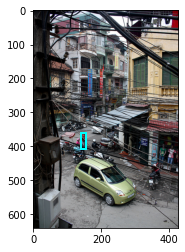

In [221]:
mycoco.load_img(1124)
mycoco.show_original_bbox()
#mycoco.show_crop()

In [223]:
img, hp, confidence= mycoco[1124]  #1124
print(mycoco.target_kp)
print(mycoco.keypoint)

id:  000000563542
torch.Size([256, 192, 3])
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
coordinate:  (0, 0)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


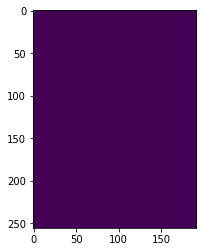

In [229]:
plt.imshow(np.stack(hp).max(axis=0))

In [231]:
training_data = CustomCOCO(train_coco_json_path, train_coco_img_path)
#test_data = CustomCOCO(test_coco_json_path, test_coco_img_path)

In [232]:
train_dataloader = DataLoader(training_data, batch_size=5, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [233]:
for i, (image, label, visibility) in enumerate(train_dataloader):
    print("i: ",i)
    #plt.imshow(image)

id:  000000116397
id:  000000478351
id:  000000091056
id:  000000332547
id:  000000426542
i:  0
id:  000000181509
id:  000000538977
id:  000000134285
id:  000000533519
id:  000000511269
i:  1
id:  000000010689
id:  000000368205
id:  000000388453
id:  000000321410
id:  000000254078
i:  2
id:  000000462398
id:  000000545363
id:  000000267862
id:  000000239792
id:  000000359686
i:  3
id:  000000016496
id:  000000211743
id:  000000036841
id:  000000244530
id:  000000373686
i:  4
id:  000000375380
id:  000000158567
id:  000000476412
id:  000000251008
id:  000000418907
i:  5
id:  000000539719
id:  000000194800
id:  000000509971
id:  000000320944
id:  000000243207
i:  6
id:  000000408386
id:  000000004736
id:  000000501197
id:  000000300881
id:  000000053672
i:  7
id:  000000218578
id:  000000009745
id:  000000437049
id:  000000495445
id:  000000096043
i:  8
id:  000000194842
id:  000000015726
id:  000000216694
id:  000000342271
id:  000000414499
i:  9
id:  000000359909
id:  000000120511
id: 

error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


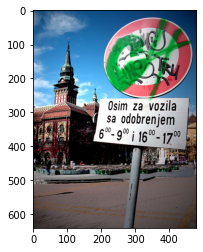

In [234]:
# Show image
img_path = '000000132883'
img_path = train_coco_img_path + img_path + '.jpg'
target_image = cv2.imread(img_path)
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)

target_bbox = target_data['bbox']
X,Y,width,height = target_bbox
X,Y,width,height = int(X),int(Y), int(width)+1, int(height)+1

plt.imshow(target_image)
ax = plt.gca()
rect = patches.Rectangle((X,Y), width, height, linewidth=2, edgecolor='cyan', fill = False)
ax.add_patch(rect)
plt.show()

In [18]:
train_features, train_labels = next(iter(train_dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze()
# hp = train_labels[0]
# plt.imshow(img)

img size before resizing:  0


error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
